# Face Expression Recognition for Hospitalized People

In [1]:
import seaborn as sns
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator

In [2]:
!unzip data\ -\ Copy.zip

Streaming output truncated to the last 5000 lines.
 extracting: data - Copy/train/6/28484.png  
 extracting: data - Copy/train/6/28485.png  
 extracting: data - Copy/train/6/28493.png  
 extracting: data - Copy/train/6/28499.png  
 extracting: data - Copy/train/6/28507.png  
 extracting: data - Copy/train/6/28517.png  
 extracting: data - Copy/train/6/28519.png  
 extracting: data - Copy/train/6/28520.png  
 extracting: data - Copy/train/6/28524.png  
 extracting: data - Copy/train/6/28530.png  
 extracting: data - Copy/train/6/28531.png  
 extracting: data - Copy/train/6/28535.png  
 extracting: data - Copy/train/6/28537.png  
 extracting: data - Copy/train/6/28539.png  
 extracting: data - Copy/train/6/28540.png  
 extracting: data - Copy/train/6/28545.png  
 extracting: data - Copy/train/6/28546.png  
 extracting: data - Copy/train/6/28549.png  
 extracting: data - Copy/train/6/28550.png  
 extracting: data - Copy/train/6/28551.png  
 extracting: data - Copy/train/6/2856.png  
 extr

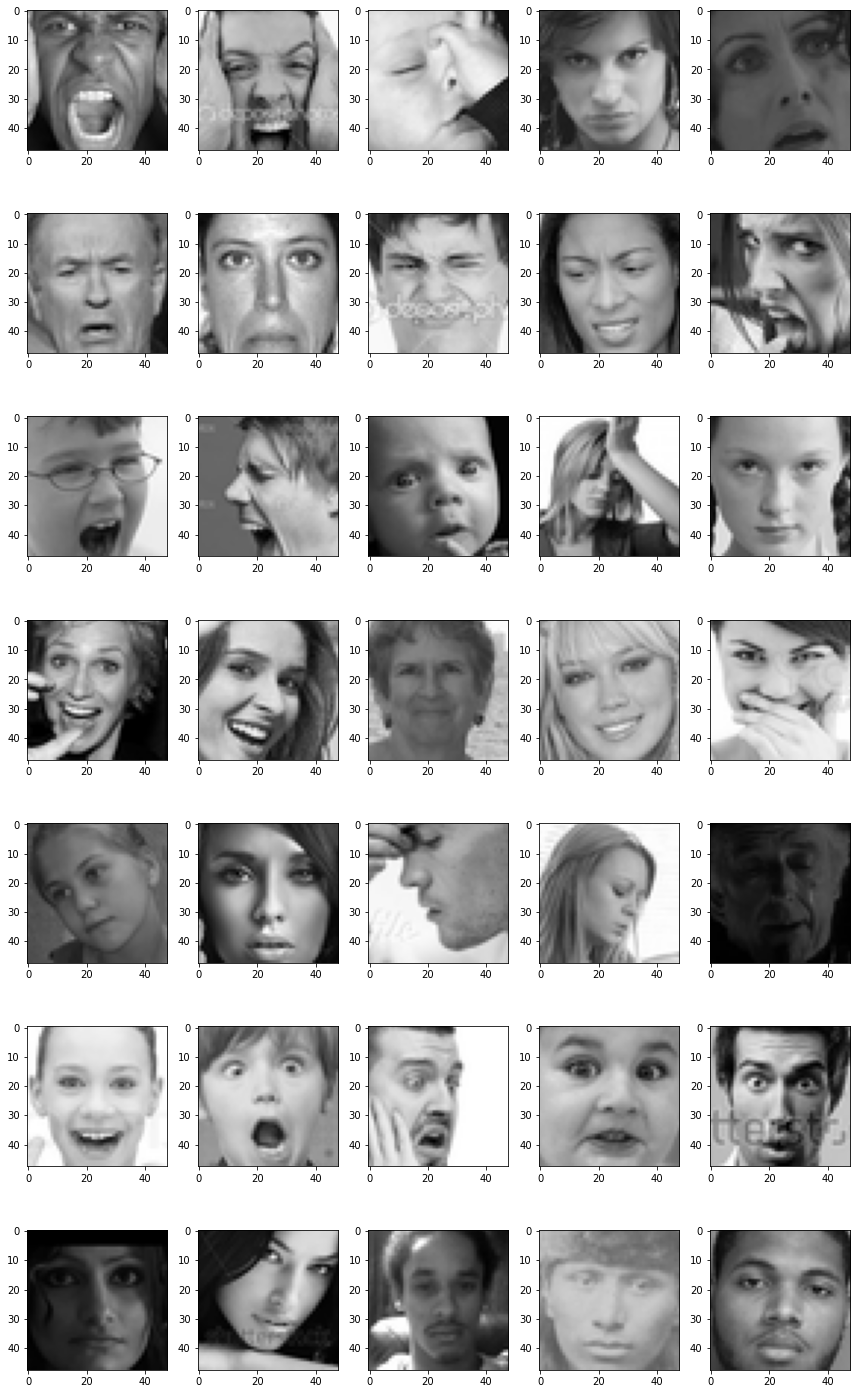

In [2]:
import numpy as np

from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "data - Copy/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "test"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "test/" + expression + "/" +os.listdir(base_path + "test/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [3]:
img = cv2.imread("data - Copy/test/1/32476.png")
print(img.shape)

(48, 48, 3)


# Data Augmentation

In [4]:

batch_size = 128
base_path = "data - Copy/"


train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(base_path + "train",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(base_path + "val",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


# Initializing CNN Architecture

In [5]:
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       5

# Training our model

In [7]:
%%time

# number of epochs to train the NN
epochs = 250

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("my_modelweight.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/250
224/224 [==============================] - ETA: 0s - loss: 2.0347 - accuracy: 0.2187
Epoch 00001: val_accuracy improved from -inf to 0.24972, saving model to my_modelweight.h5
224/224 [==============================] - 41s 126ms/step - loss: 2.0347 - accuracy: 0.2187 - val_loss: 1.8847 - val_accuracy: 0.2497
Epoch 2/250
224/224 [==============================] - ETA: 0s - loss: 1.9195 - accuracy: 0.2413
Epoch 00002: val_accuracy improved from 0.24972 to 0.26451, saving model to my_modelweight.h5
224/224 [==============================] - 27s 122ms/step - loss: 1.9195 - accuracy: 0.2413 - val_loss: 1.9217 - val_accuracy: 0.2645
Epoch 3/250
224/224 [==============================] - ETA: 0s - loss: 1.8637 - accuracy: 0.2606
Epoch 00003: val_accuracy did not improve from 0.26451
224/224 [==============================] - 27s 121ms/step - loss: 1.8637 - accuracy: 0.2606 - val_loss: 1.8418 - val_accuracy: 0.2151
Epoch 4/250
224/224 [==============================] - ETA: 0s - lo

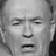

In [13]:
from keras.preprocessing import image
testing_image=image.load_img(r'data - Copy/test/1/32476.png',target_size=(56,56,3))
testing_image

In [14]:
testing_image=image.img_to_array(testing_image)

In [15]:
testing_image

array([[[ 75.,  75.,  75.],
        [ 66.,  66.,  66.],
        [ 63.,  63.,  63.],
        ...,
        [108., 108., 108.],
        [114., 114., 114.],
        [112., 112., 112.]],

       [[ 77.,  77.,  77.],
        [ 64.,  64.,  64.],
        [ 52.,  52.,  52.],
        ...,
        [106., 106., 106.],
        [109., 109., 109.],
        [108., 108., 108.]],

       [[ 67.,  67.,  67.],
        [ 48.,  48.,  48.],
        [ 70.,  70.,  70.],
        ...,
        [105., 105., 105.],
        [106., 106., 106.],
        [107., 107., 107.]],

       ...,

       [[148., 148., 148.],
        [148., 148., 148.],
        [144., 144., 144.],
        ...,
        [ 36.,  36.,  36.],
        [ 29.,  29.,  29.],
        [ 12.,  12.,  12.]],

       [[145., 145., 145.],
        [149., 149., 149.],
        [150., 150., 150.],
        ...,
        [ 30.,  30.,  30.],
        [ 34.,  34.,  34.],
        [ 30.,  30.,  30.]],

       [[146., 146., 146.],
        [147., 147., 147.],
        [149., 1

In [16]:
testing_image = testing_image/255.0
testing_image

array([[[0.29411766, 0.29411766, 0.29411766],
        [0.25882354, 0.25882354, 0.25882354],
        [0.24705882, 0.24705882, 0.24705882],
        ...,
        [0.42352942, 0.42352942, 0.42352942],
        [0.44705883, 0.44705883, 0.44705883],
        [0.4392157 , 0.4392157 , 0.4392157 ]],

       [[0.3019608 , 0.3019608 , 0.3019608 ],
        [0.2509804 , 0.2509804 , 0.2509804 ],
        [0.20392157, 0.20392157, 0.20392157],
        ...,
        [0.41568628, 0.41568628, 0.41568628],
        [0.42745098, 0.42745098, 0.42745098],
        [0.42352942, 0.42352942, 0.42352942]],

       [[0.2627451 , 0.2627451 , 0.2627451 ],
        [0.1882353 , 0.1882353 , 0.1882353 ],
        [0.27450982, 0.27450982, 0.27450982],
        ...,
        [0.4117647 , 0.4117647 , 0.4117647 ],
        [0.41568628, 0.41568628, 0.41568628],
        [0.41960785, 0.41960785, 0.41960785]],

       ...,

       [[0.5803922 , 0.5803922 , 0.5803922 ],
        [0.5803922 , 0.5803922 , 0.5803922 ],
        [0.5647059 , 0

# Plotting graph training and validation accuracy and loss

In [9]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
 
# print best epoch with best accuracy on validation

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

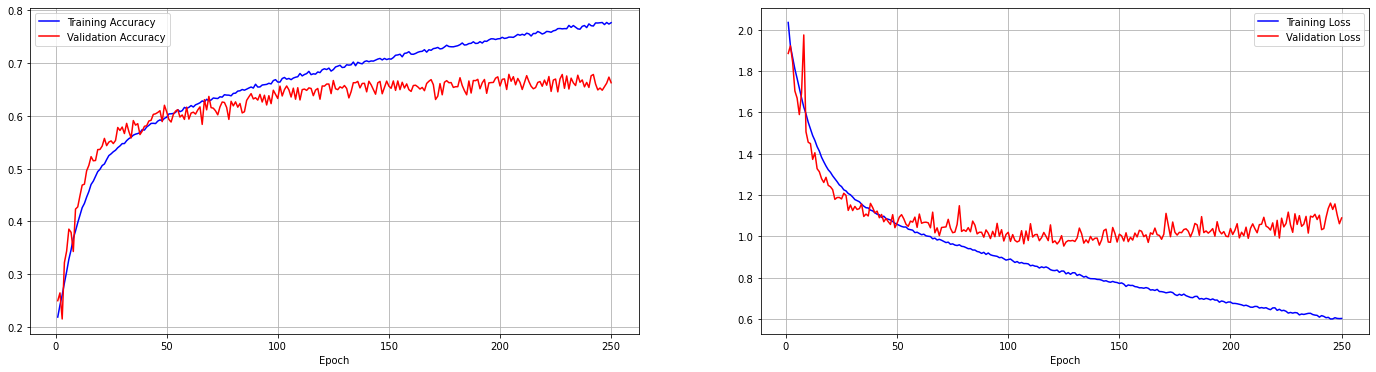

Best Validation Accuracy Score 0.67857, is for epoch 204


In [10]:
plot_results(history)
best_epoch =get_best_epcoh(history)

# Real Time Application

In [6]:
import numpy as np
import cv2
from tensorflow.keras.models import model_from_json

In [7]:
model_json_file = 'model1.json'
model_weights_file = 'model_weights.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)

In [8]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
cap = cv2.VideoCapture(0)
import copy
import imutils

while True:
    
    ret, frame = cap.read()
    frame = imutils.resize(frame,width=1300)
    img = copy.deepcopy(frame)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        fc = gray[y:y+h, x:x+w]
        
        roi = cv2.resize(fc, (48,48))
        pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
        text_idx=np.argmax(pred)
        text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
        if text_idx == 0:
            text= text_list[0]
        if text_idx == 1:
            text= text_list[1]
        elif text_idx == 2:
            text= text_list[2]
        elif text_idx == 3:
            text= text_list[3]
        elif text_idx == 4:
            text= text_list[4]
        elif text_idx == 5:
            text= text_list[5]
        elif text_idx == 6:
            text= text_list[6]
        cv2.putText(img, text, (x, y-5),
           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
        img = cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
    cv2.imshow("frame", img)
    
    key = cv2.waitKey(1) & 0xFF
    if key== ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

AttributeError: ignored

# OpenCV for live Webcam and music player

In [9]:
cap = cv2.VideoCapture(0)
import copy
import imutils
from gtts import gTTS
import os
import time
import random
from playsound import playsound
from tkinter import *

# Creating the tkinter window
root = Tk()
root.geometry("1100x900")

img = PhotoImage(file="W3.png")
label = Label(
    root,
    image=img
)
label.place(x=0, y=0)
root.mainloop()
exit(0)
myText7 = "Welcome to Facial Expression Recognition System and kindly keep your head straight"
output7 = gTTS(text=myText7,lang='en',slow=False)
output7.save("output7.mp3")
playsound('output7.mp3')
os.remove("output7.mp3")

while True:
    
    ret, frame = cap.read()
    frame = imutils.resize(frame,width=1300)
    img = copy.deepcopy(frame)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        fc = gray[y:y+h, x:x+w]
        
        roi = cv2.resize(fc, (48,48))
        pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
        text_idx=np.argmax(pred)
        text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
        
        if text_idx == 0:
            text= text_list[0]      
        if text_idx == 1:
            text= text_list[1]
        elif text_idx == 2:
            text= text_list[2]
        elif text_idx == 3:
            text= text_list[3]
        elif text_idx == 4:
            text= text_list[4]
            #myText = "You are angry"
            #output = gTTS(text=myText,lang='en',slow=False)
            #output.save("output.mp3")Surprise you want to listen happy songs here is the best song for you
            #os.system("start output.mp3")
            #camera.release()
            #cv2.destroyAllWindows()
            #time.sleep(20)
            #break
        elif text_idx == 5:
            text= text_list[5]
        elif text_idx == 6:
            text= text_list[6]
        cv2.putText(img, text, (x, y-5),
           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
        img = cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
    cv2.imshow("frame", img)
    
    key = cv2.waitKey(1) & 0xFF
    if key== ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
#def music():
    #os.system("angry.mp3")
    
# Text to speech converter
while True:    
    if text_idx == 0: 
        myText0 = "You seems like angry you want to listen happy songs here is the best song for you"
        output0 = gTTS(text=myText0,lang='en',slow=False)
        output0.save("output0.mp3")
        playsound('output0.mp3')
        os.remove("output0.mp3")
        break
    if text_idx == 1: 
        myText1 = "You seems like Disgust you want to listen happy songs here is the best song for you"
        output1 = gTTS(text=myText1,lang='en',slow=False)
        output1.save("output1.mp3")
        playsound('output1.mp3')
        os.remove("output1.mp3")
        break
    if text_idx == 2: 
        myText2 = "You seems like Fear you want to listen happy songs here is the best song for you"
        output2 = gTTS(text=myText2,lang='en',slow=False)
        output2.save("output2.mp3")
        playsound('output2.mp3')
        os.remove("output2.mp3")
        break
    if text_idx == 3: 
        myText3 = "You seems like Happy you want to listen happy songs here is the best song for you"
        output3 = gTTS(text=myText3,lang='en',slow=False)
        output3.save("output3.mp3")
        playsound("output3.mp3")
        os.remove("output3.mp3")
        break
    if text_idx == 4:   
        myText4 = "You seems like Neutral you want to listen happy songs here is the best song for you"
        output4 = gTTS(text=myText4,lang='en',slow=False)
        output4.save("output4.mp3")
        playsound("output4.mp3")
        os.remove("output4.mp3")
        break
    if text_idx == 5:   
        myText5 = "You seems like Sad you want to listen happy songs here is the best song for you"
        output5 = gTTS(text=myText5,lang='en',slow=False)
        output5.save("output5.mp3")
        playsound("output5.mp3")
        os.remove("output5.mp3")
        break
    if text_idx == 6:   
        myText6 = "You seems like Surprise you want to listen happy songs here is the best song for you"
        output6 = gTTS(text=myText6,lang='en',slow=False)
        output6.save("output6.mp3")
        playsound('output6.mp3')
        os.remove("output6.mp3")
        break

if text_idx == 0:
    n=random.randint(0,9)
    print(n)
    music_dir = 'songs/Angry'
    song = os.listdir(music_dir)
    print(song)
    os.startfile(os.path.join(music_dir,song[n])) 
if text_idx == 1:
    n=random.randint(0,9)
    print(n)
    music_dir = 'songs/Disgust'
    song = os.listdir(music_dir)
    print(song)
    os.startfile(os.path.join(music_dir,song[n]))
if text_idx == 2:
    n=random.randint(0,9)
    print(n)
    music_dir = 'songs/Fear'
    song = os.listdir(music_dir)
    print(song)
    os.startfile(os.path.join(music_dir,song[n]))
if text_idx == 3:
    n=random.randint(0,9)
    print(n)
    music_dir = 'songs/Happy'
    song = os.listdir(music_dir)
    print(song)
    os.startfile(os.path.join(music_dir,song[n]))
if text_idx == 4:
    n=random.randint(0,9)
    print(n)
    music_dir = 'songs/Neutral'
    song = os.listdir(music_dir)
    print(song)
    os.startfile(os.path.join(music_dir,song[n]))
if text_idx == 5:
    n=random.randint(0,9)
    print(n)
    music_dir = 'songs/Sad'
    song = os.listdir(music_dir)
    print(song)
    os.startfile(os.path.join(music_dir,song[n]))
if text_idx == 6:
    n=random.randint(0,9)
    print(n)
    music_dir = 'songs/Surprise'
    song = os.listdir(music_dir)
    print(song)
    os.startfile(os.path.join(music_dir,song[n]))
    

9
['neutral1.mp3', 'neutral10.mp3', 'neutral2.mp3', 'neutral3.mp3', 'neutral4.mp3', 'neutral5.mp3', 'neutral6.mp3', 'neutral7.mp3', 'neutral8.mp3', 'neutral9.mp3']
